In [1]:
import jax 
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import json
import scipy.sparse
from scipy.sparse.linalg import expm, eigs
import matplotlib.pyplot as plt

In [32]:
with open("config.json", "r") as f:
    config = json.load(f)

In [45]:
dt = config["physics"]["time_step"]
temp = 1.0
gamma = 0.1 #jax_md default
sigma_half = gamma*temp

In [40]:
@jax.jit
def pande_potential(x):
    """
    See Example 1 of "Modeling Molecular Kinetics with tICA and the Kernel Trick" 10.1021/ct5007357
    """
    return 4*(x**8+ 0.8*jnp.exp(-80*(x**2)) +  0.2*jnp.exp(-80*((x - 0.5)**2)) + 0.5*jnp.exp(-40*((x + 0.5)**2)))

force = jax.grad(pande_potential)

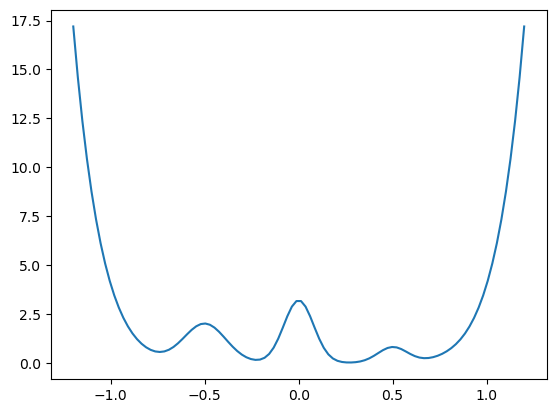

In [7]:
x = jnp.linspace(-1.2, 1.2, 100)
plt.plot(x, jax.vmap(pande_potential)(x))

In [172]:
from discretize import TensorMesh
num = 50
interval = 2.0
width = interval/num
h = width*np.ones(num)
mesh = TensorMesh([h, 2*h], origin='CC')
mesh.set_cell_gradient_BC('neumann')

[['neumann', 'neumann'], ['neumann', 'neumann']]

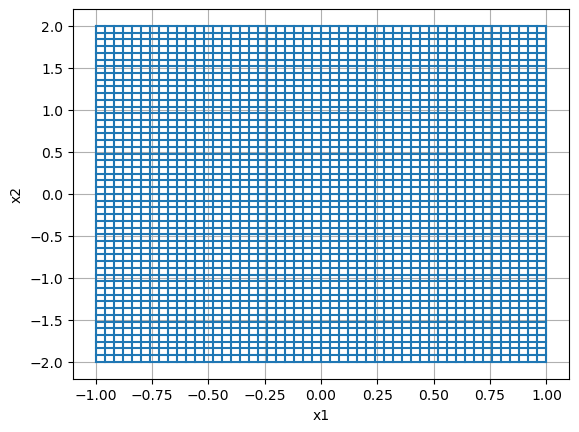

In [173]:
fig, ax = plt.subplots()
mesh.plot_grid(ax = ax)
plt.show()

In [174]:
format = 'csc'
grad_Q = (mesh.average_face_x_to_cell.dot(mesh.cell_gradient_x)).asformat(format)
grad_P = (mesh.average_face_y_to_cell.dot(mesh.cell_gradient_y)).asformat(format)
lap_P = (grad_P.dot(grad_P)).asformat(format)
grad_V = scipy.sparse.diags(np.asarray(jax.vmap(force)(mesh.cell_centers[:, 0])), format=format)
Q = scipy.sparse.diags(mesh.cell_centers[:, 0], format=format)
P = scipy.sparse.diags(mesh.cell_centers[:, 1], format=format)

In [175]:
fokker_planck = sigma_half*lap_P - P.dot(grad_Q) +grad_V.dot(grad_P) - gamma*P.dot(grad_P)

In [220]:
eigs(dt*fokker_planck, return_eigenvectors=False)

array([-2.93286008e-03+0.03433358j, -2.93286008e-03-0.03433358j,
       -8.23783694e-05-0.03460555j, -8.23783694e-05+0.03460555j,
       -8.25797987e-05+0.03461614j, -8.25797987e-05-0.03461614j])

In [22]:
computed_vals_old = np.load('../../../KoopmanMD/data/evals_data.npy')[0]
computed_vals = np.load('data/evals_data.npy')[0]

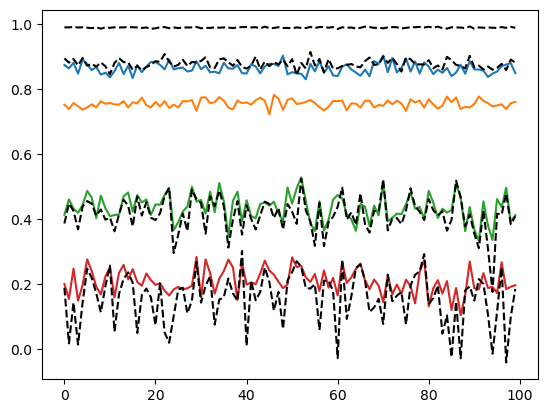

In [23]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig, ax = plt.subplots()

for i in range(4):
    ax.plot(computed_vals[:, i].real, c=colors[i])
    ax.plot(computed_vals_old[:, i].real, 'k--')